In [ ]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image

# Data Preprocessing

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.1307,), (0.3081,))])
# Train
trainset = tv.datasets.MNIST(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
# Test
testset = tv.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False, num_workers=2)

'''
# Defining Model

class Autoencoder(nn.Module):

    def __init__(self):
        super(Autoencoder,self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),  # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=5),
            nn.ReLU(True))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16,6,kernel_size=5),  # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1)
            nn.ReLU(True),
            nn.ConvTranspose2d(6,1,kernel_size=5),
            nn.ReLU(True),
            nn.Sigmoid())

    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
'''
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=10):
        super(ConvAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            # Input: 1x28x28 (MNIST images)
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # Output: 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Output: 32x7x7
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: 64x4x4 #Output was 64x3x3
            nn.ReLU(),
            nn.Flatten(),  # Flatten to 64*4*4 = 1024 #Flatten to 64*3*3 = 576
            nn.Linear(1024, latent_dim)  # Output: latent_dim #nn.Linear(576, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),  # Output: 1024 #nn.Linear(latent_dim, 576)
            nn.Unflatten(1, (64, 4, 4)),  # Reshape to 64x4x4 #nn.Unflatten(1, (64, 3, 3))
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 32x7x7
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: 16x14x14
            nn.ReLU(),
            # Adjusted the final ConvTranspose2d layer to output 28x28 images
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=3, output_padding=1),  # Output: 1x28x28
            nn.Sigmoid()  # Ensure output is in the range [0, 1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed


num_epochs = 5
batch_size = 128
model = ConvAutoencoder(latent_dim=10).cpu()
#model = Autoencoder().cpu()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = Variable(img).cpu()
        # ===================forward=====================

        #print(img.shape)
        output = model(img)
        #print(output.shape)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

epoch [1/5], loss:0.4899
epoch [2/5], loss:0.4782
epoch [3/5], loss:0.4723
epoch [4/5], loss:0.4695
epoch [5/5], loss:0.4686


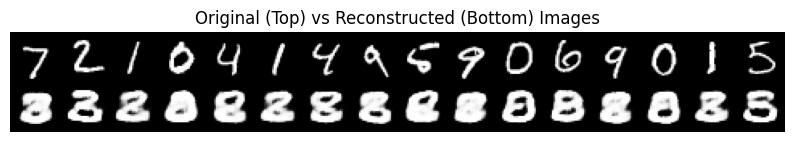

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image

# Load the MNIST test dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=16, shuffle=False)

# Load the trained model (assuming it's already defined and trained)
# model = ConvAutoencoder(latent_dim=10)
# model.load_state_dict(torch.load('autoencoder.pth'))  # Load saved weights if needed
model.eval()  # Set the model to evaluation mode

# Obtain one batch of test images
for data in testloader:
    img, _ = data
    img = Variable(img).cpu()  # Move images to CPU (if using GPU, change to .cuda())

    # Forward pass: Get reconstructed images
    with torch.no_grad():  # Disable gradient computation
        output = model(img)

    # Save the original and reconstructed images in a grid
    save_image(torch.cat([img, output], dim=0), 'test_results1.png', nrow=img.shape[0])
    break

# Display the saved image
result_image = Image.open('test_results1.png')
plt.figure(figsize=(10, 5))
plt.imshow(result_image)
plt.axis('off')
plt.title('Original (Top) vs Reconstructed (Bottom) Images')
plt.show()